In [1]:
%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cpu].
CPU times: user 1.88 s, sys: 436 ms, total: 2.32 s
Wall time: 1.31 s


In [2]:
%%time

dataset = create_dataset('criteo', sample_num=100000, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 4.05 s, sys: 289 ms, total: 4.34 s
Wall time: 4.34 s


In [3]:
class LogisticRegression(nn.Module):
    
    def __init__(self, field_dims):
        super(LogisticRegression, self).__init__()
        
        self.bias = nn.Parameter(torch.zeros((1, )))
        self.embed = FeaturesEmbedding(field_dims, 1)

    def forward(self, x):
        # x shape: (batch_size, num_fields)
        output = self.embed(x).sum(dim=1) + self.bias
        output = torch.sigmoid(output)
        return output


class Classifier(nn.Module):

    def __init__(self, field_dims, k):
        super(Classifier, self).__init__()

        self.embed = FeaturesEmbedding(field_dims, k)

    def forward(self, x):
        # x shape: (batch_size, num_fields)
        # embed(x) shape: (batch_size, num_fields, embed_dim)
        # output shape: (batch_size, k)
        output = self.embed(x).sum(dim=1)

        # output shape: (batch_size, k)
        output = torch.softmax(output, dim=1)
        return output

    
class MixedLogisticRegression(nn.Module):
    
    def __init__(self, field_dims, k=5):
        super(MixedLogisticRegression, self).__init__()

        self.clf = Classifier(field_dims, k)
        self.lr_list = nn.ModuleList([LogisticRegression(field_dims) for _ in range(k)])

    def forward(self, x):
        clf_output = self.clf(x)
        lr_output = torch.zeros_like(clf_output)
        for i, lr in enumerate(self.lr_list):
            lr_output[:, i] = lr(x).squeeze(-1)
        output = torch.mul(clf_output, lr_output).sum(dim=1, keepdim=True)
        return output


 30%|███       | 181/600 [02:12<05:06,  1.37it/s]


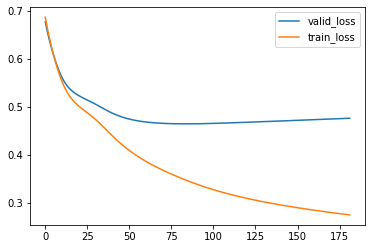

train_loss: 0.34961 | train_metric: 0.90295
valid_loss: 0.46444 | valid_metric: 0.75574
test_loss:  0.44885 | test_auc:  0.76579
CPU times: user 7min 4s, sys: 47.9 s, total: 7min 51s
Wall time: 2min 12s


In [4]:
%%time

LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

mlr = MixedLogisticRegression(field_dims).to(device)
optimizer = optim.Adam(mlr.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(mlr, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))
